# &nbsp;Install Library

In [12]:
import os
import random
import gdown
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
import pandas as pd
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

INPUT_SIZE = (224, 224)
CUSTOM_MODEL_NAME = 'model-pretrained'

WORKING_PATHS = {
    'BASE': os.path.join('workspace'),
    'DATASET': os.path.join('workspace', 'dataset'),
    'TRAIN_DATASET': os.path.join('workspace', 'dataset', 'train'),
    'TEST_DATASET': os.path.join('workspace', 'dataset', 'test'),
    'OUTPUT': os.path.join('workspace', 'output'),
    'EXPORT': os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'export'),
    'TFLITE':os.path.join('workspace', 'output', CUSTOM_MODEL_NAME, 'tfliteexport'),
 }

# &nbsp;Create Directory

In [13]:
for path in WORKING_PATHS.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# &nbsp;Collect Dataset

In [14]:
ARCHIVED_NAME = 'BISINDO.zip'
ARCHIVED_ID = '1vLSGvowCyhpcn7kvH5SRk_Z2OEfP8fRF'
GLINK = 'https://drive.google.com/uc?id={}'.format(ARCHIVED_ID)

if not os.path.exists(os.path.join(WORKING_PATHS['DATASET'], ARCHIVED_NAME)):
    if os.name == 'posix':
        !gdown {GLINK}
        !mv {ARCHIVED_NAME} {WORKING_PATHS['DATASET']}
        !cd {WORKING_PATHS['DATASET']} && unzip -a {ARCHIVED_NAME}
    if os.name == 'nt':
        gdown.download(GLINK, ARCHIVED_NAME, quiet = False)
        !move {ARCHIVED_NAME} {WORKING_PATHS['DATASET']}
        !cd {WORKING_PATHS['DATASET']} && tar -zxvf {ARCHIVED_NAME}

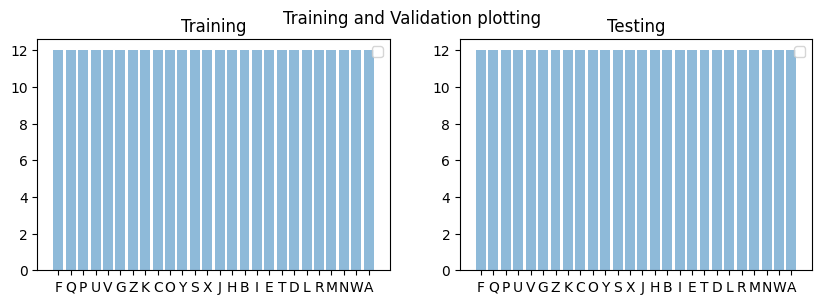

In [15]:
static_labels = os.listdir(WORKING_PATHS['TRAIN_DATASET'])
TRAIN_IMG_MIN = 9999
train_data_num = {}
test_data_num = {}

for label in static_labels:
    train_data_num[label] = len(os.listdir(os.path.join(WORKING_PATHS['TRAIN_DATASET'], label)))
    test_data_num[label] = len(os.listdir(os.path.join(WORKING_PATHS['TEST_DATASET'], label)))
    if train_data_num[label] < TRAIN_IMG_MIN:
        TRAIN_IMG_MIN = train_data_num[label]

y_pos = np.arange(len(static_labels))
train_values = train_data_num.values()
test_values = test_data_num.values()

fig, axs = plt.subplots(1, 2, figsize = (10, 3))
fig.suptitle('Training and Validation plotting')
axs[0].bar(y_pos, train_values, align = 'center', alpha = 0.5)
axs[0].set_xticks(y_pos, static_labels)
axs[0].set_title('Training')
axs[0].legend()
axs[1].bar(y_pos, test_values, align = 'center', alpha = 0.5)
axs[1].set_xticks(y_pos, static_labels)
axs[1].set_title('Testing')
axs[1].legend()

plt.show()

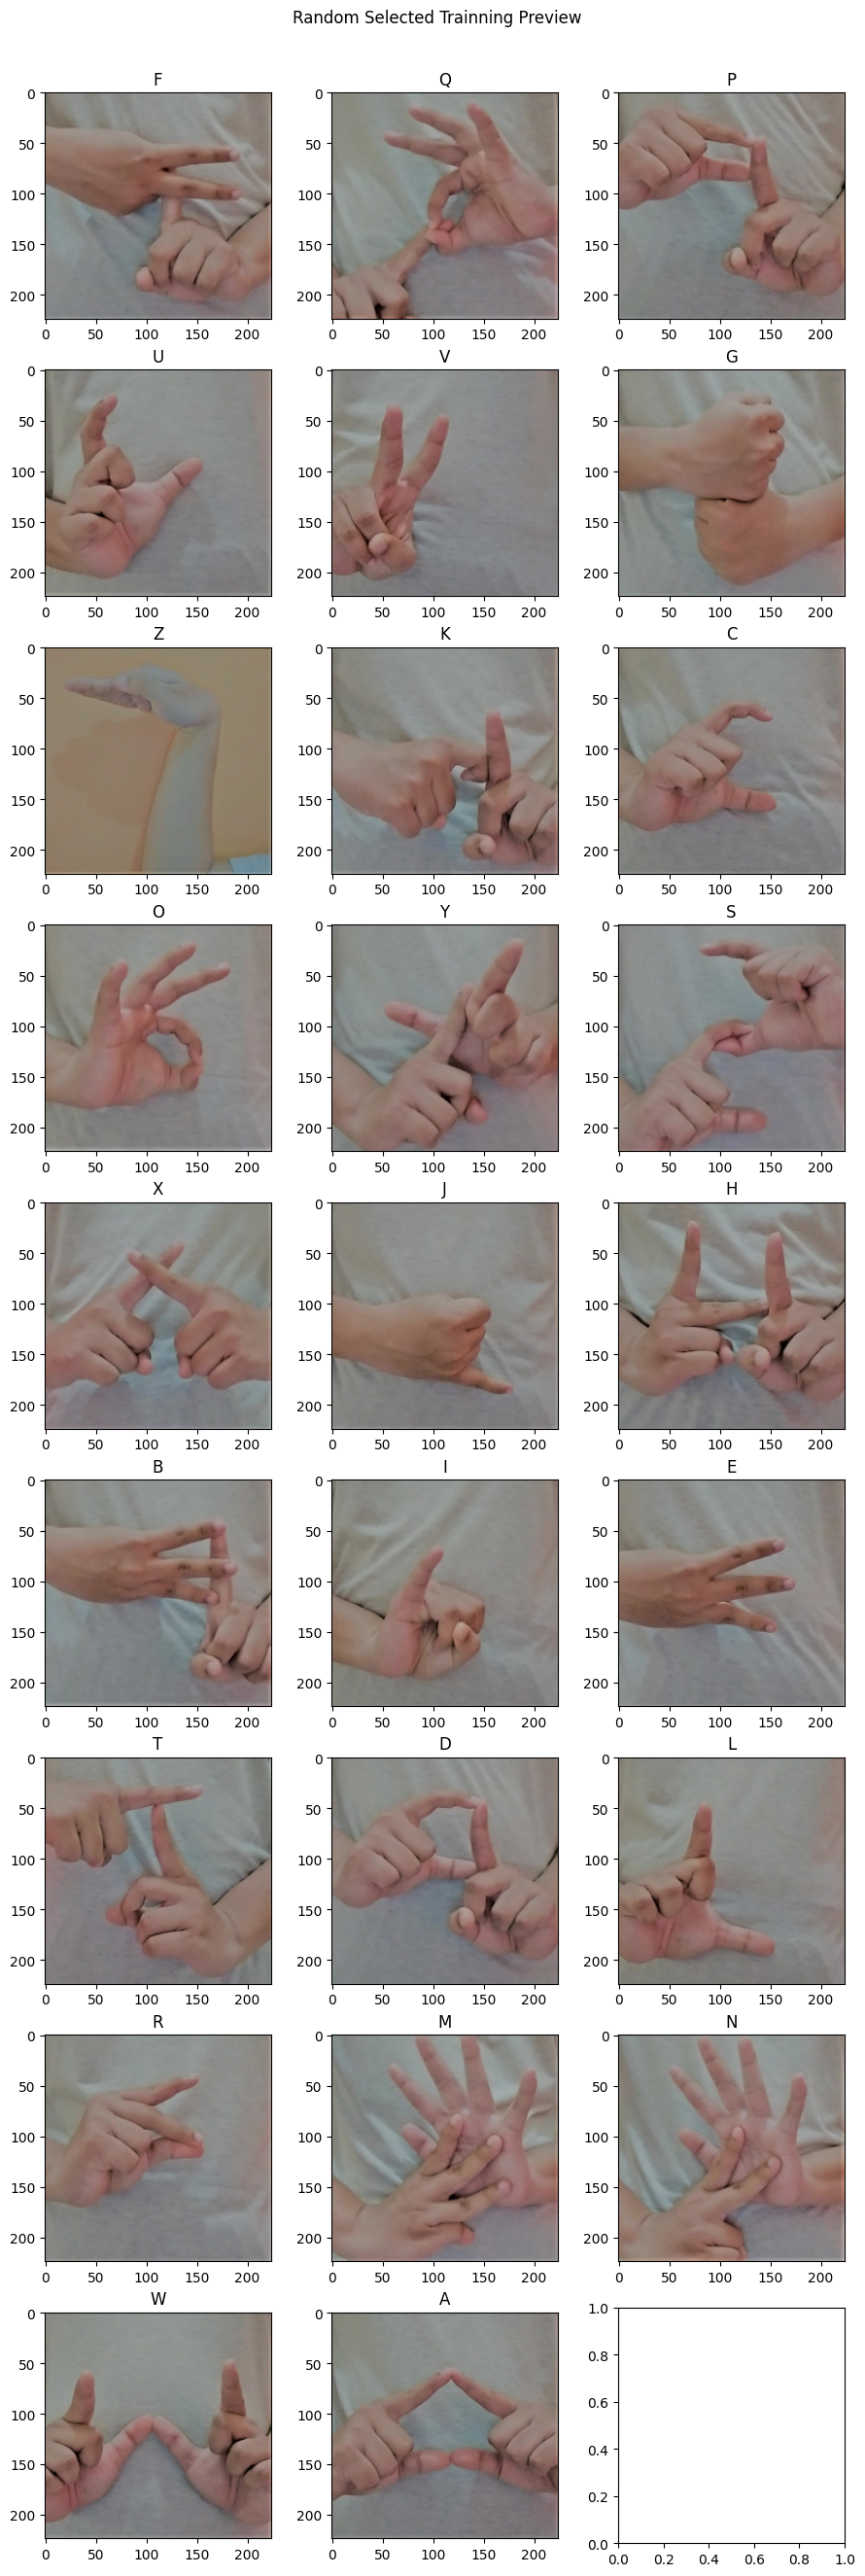

In [16]:
seed = random.randint(0, TRAIN_IMG_MIN)

cols = 3
rows = math.ceil(len(static_labels) / 3)

fig_size = 3
fig, axs = plt.subplots(rows, cols, figsize = ((fig_size * cols), (fig_size * rows)))
fig.suptitle('Random Selected Trainning Preview')
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
axs = axs.ravel()

img_dict = {}
for idx, label in enumerate(static_labels):
    img_path = os.path.join(WORKING_PATHS['TRAIN_DATASET'], label)
    img_rand = os.listdir(img_path)[seed]
    img_selc = image.load_img(os.path.join(img_path, img_rand))

    axs[idx].imshow(img_selc.resize(INPUT_SIZE))
    axs[idx].set_title(label)

# &nbsp;Preprocessing

In [17]:
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1 / 255)

train_generator = train_datagen.flow_from_directory(
    WORKING_PATHS['TRAIN_DATASET'],
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    WORKING_PATHS['TEST_DATASET'],
    target_size = INPUT_SIZE,
    class_mode = 'categorical'
)

Found 312 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [18]:
LABELS = list(train_generator.class_indices.keys())
NUM_CLASSES = len(LABELS)
print(NUM_CLASSES)

26


In [19]:
class EarlyStoppingAtGivenAccuracy(keras.callbacks.Callback):
    """
        Stop training when the accuracy at given threshold
    """
    def __init__(self, threshold = 0.9):
        super(EarlyStoppingAtGivenAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        acc = logs.get('accuracy')
        if acc is not None:
            if acc >= self.threshold:
                print('Epoch {}: Reached baseline, stop training'.format(epoch))
                self.model.stop_training = True

# &nbsp;Build Model

In [20]:
from tensorflow.keras.applications import MobileNetV2

pre_trained_model = MobileNetV2(
    weights = 'imagenet',
    input_shape = (INPUT_SIZE[0], INPUT_SIZE[1], 3),
    include_top = False,
)

pre_trained_model.trainable = False

In [21]:
pre_trained_model.trainable = True

for layer in pre_trained_model.layers[:100]:
    layer.trainable = False

# &nbsp;Train Model

In [22]:
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(NUM_CLASSES, activation = 'softmax')(x)

model = Model(inputs = pre_trained_model.input, outputs = x)

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
])

model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

callback = EarlyStoppingAtGivenAccuracy(0.97)
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 40,
    validation_steps = 5,
    verbose = 1,
    # callbacks = [callback]
)

Epoch 1/40
10/10 [==============================] - 60s 5s/step - loss: 4.5916 - accuracy: 0.1186 - val_loss: 3.2921 - val_accuracy: 0.2937
Epoch 2/40
10/10 [==============================] - 62s 6s/step - loss: 2.0259 - accuracy: 0.4423 - val_loss: 2.0307 - val_accuracy: 0.4000
Epoch 3/40
10/10 [==============================] - 50s 5s/step - loss: 0.9049 - accuracy: 0.7436 - val_loss: 1.4524 - val_accuracy: 0.5188
Epoch 4/40
10/10 [==============================] - 51s 5s/step - loss: 0.5715 - accuracy: 0.8429 - val_loss: 1.7688 - val_accuracy: 0.5188
Epoch 5/40
10/10 [==============================] - 50s 5s/step - loss: 0.2957 - accuracy: 0.9295 - val_loss: 2.1509 - val_accuracy: 0.4812
Epoch 6/40
10/10 [==============================] - 51s 5s/step - loss: 0.2920 - accuracy: 0.9167 - val_loss: 1.1095 - val_accuracy: 0.6687
Epoch 7/40
10/10 [==============================] - 50s 5s/step - loss: 0.2554 - accuracy: 0.9167 - val_loss: 1.3962 - val_accuracy: 0.6313
Epoch 8/40
10/10 [==

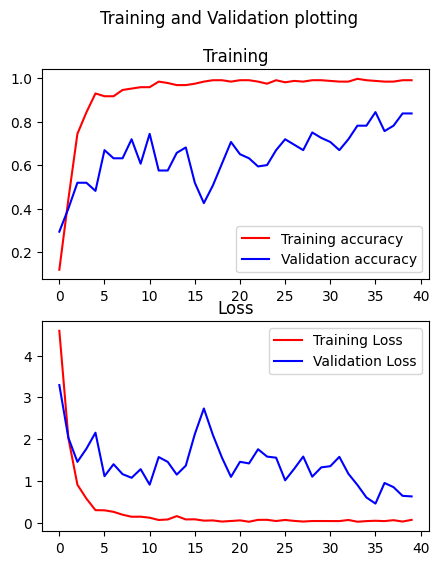

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(2, 1, figsize = (5, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc, 'b', label = 'Validation accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[1].plot(epochs, loss, 'r', label = 'Training Loss')
axs[1].plot(epochs, val_loss, 'b', label = 'Validation Loss')
axs[1].set_title('Loss')
axs[1].legend()
plt.show()

In [25]:
model.compile(
    optimizer = Adam(learning_rate = 0.000001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Start Training!
callback = EarlyStoppingAtGivenAccuracy(0.9999)
history2 = model.fit(
    train_generator,
    validation_data = validation_generator,
    initial_epoch = 40,
    epochs = 50,
    validation_steps = 5,
    verbose = 1,
    callbacks = [callback]
)

Epoch 41/50
10/10 [==============================] - 67s 5s/step - loss: 0.0201 - accuracy: 0.9936 - val_loss: 0.6777 - val_accuracy: 0.8625
Epoch 42/50
10/10 [==============================] - 53s 5s/step - loss: 0.0258 - accuracy: 0.9904 - val_loss: 0.3377 - val_accuracy: 0.9187
Epoch 43/50
10/10 [==============================] - 51s 5s/step - loss: 0.0151 - accuracy: 0.9904 - val_loss: 0.4541 - val_accuracy: 0.8938
Epoch 44/50
10/10 [==============================] - 59s 6s/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.5169 - val_accuracy: 0.8938


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(acc) + len(acc2))

fig, axs = plt.subplots(2, 1, figsize = (10, 6))
fig.suptitle('Training and Validation plotting')
axs[0].plot(epochs, acc + acc2, 'r', label = 'Training accuracy')
axs[0].plot(epochs, val_acc + val_acc2, 'b', label = 'Validation Training accuracy')
axs[0].set_title('Training')
axs[0].legend()
axs[0].axvline(x = len(acc))
axs[1].plot(epochs, loss + loss2, 'r', label = 'Loss accuracy')
axs[1].plot(epochs, val_loss + val_loss2, 'b', label = 'Validation Loss accuracy')
axs[1].set_title('Loss')
axs[1].legend()
axs[1].axvline(x = len(acc))
plt.show()

In [ ]:
def selectRandomImage(labels = None):
    if labels == None:
        seed = random.randint(1, NUM_CLASSES)
        label_seed = LABELS[seed - 1]
    else:
        seed = random.randint(1, len(labels))
        label_seed = labels[seed - 1]

    path = os.path.join(WORKING_PATHS['TRAIN_DATASET'], label_seed)
    test_dir = os.listdir(path)
    test_dir_num = len(test_dir)
    file_name = os.listdir(path)[random.randint(0, test_dir_num - 1)]
    return (os.path.join(path, file_name), file_name, label_seed)

In [ ]:
def createResultPlot(prediction_list, prediction_label, actual_label, file_name):

    fig, axs = plt.subplots(1, 2, figsize = (10, 5))
    fig.suptitle('Image {} predict as: {}'.format(file_name, prediction_label))
    fig.subplots_adjust(top = 2)
    fig.tight_layout()
    axs = axs.ravel()

    if prediction_label == actual_label:
        fig.patch.set_facecolor('xkcd:mint green')
    else:
        fig.patch.set_facecolor('xkcd:pale pink')


    axs[0].set_title(actual_label)
    axs[0].imshow(img)


    axs[1].set_title('Probabilities')
    axs[1].bar(range(0, NUM_CLASSES), prediction_list, align = 'center')
    axs[1].set_xticks(range(0, NUM_CLASSES))
    axs[1].set_xticklabels(LABELS)

    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

file_path, file_name, label = selectRandomImage(['G'])
img = image.load_img(file_path, target_size = INPUT_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

prediction = model.predict(x, batch_size = 10)
index = int(prediction[0].argmax(axis = -1))

createResultPlot(prediction[0].reshape(NUM_CLASSES), LABELS[index], label, file_name)

In [ ]:


y_true = []
y_pred = []

for label in LABELS:
    path = os.path.join(WORKING_PATHS['TEST_DATASET'], label)
    files = os.listdir(path)
    for idx, file_name in enumerate(files):
        file_loc = os.path.join(path, file_name)
        img = image.load_img(file_loc, target_size = INPUT_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x)

        prediction = model.predict(x, batch_size = 10)
        index = int(prediction[0].argmax(axis = -1))
        y_true.append(label)
        y_pred.append(LABELS[index])

mat = confusion_matrix(y_true, y_pred, labels = LABELS)


mat_norm = mat / mat.astype(np.float).sum(axis = 1)

In [ ]:
df_cm = pd.DataFrame(mat_norm, index = LABELS, columns = LABELS)

plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot = True)
ax.set_title("Test Confussion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.show()

In [ ]:
model.save(os.path.join(os.getcwd(), WORKING_PATHS['EXPORT']))

# &nbsp;Convert to TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(WORKING_PATHS['EXPORT'])
tflite_model = converter.convert()

with open(os.path.join(WORKING_PATHS['TFLITE'], 'model.tflite'), 'wb') as f:
  f.write(tflite_model)